# Overview

This notebook presents several classifiers aiming to predict startups success (aquired or failed, no IPO data in the imput dataset) based on the avaliable data.
 For the input data analysis, please view EDA notebood in the same repository.
 The dataset can be found here: https://www.kaggle.com/datasets/manishkc06/startup-success-prediction/data

 # Take code from git

In [1]:
# !rm -r Applied_DS_Project # pay attention!
# !git clone https://github.com/MayaVB/Applied_DS_Project.git

In [2]:
# !ls Applied_DS_Project

In [3]:
# !ls Applied_DS_Project/src

# Install requirements

In [4]:
# !pip install -r Applied_DS_Project/requirements.txt

In [5]:
# consider for future features
# %pip install yfinance
# %pip install tweepy
# %pip install wbdata pandas
# %pip install xgboost

# Imports

In [6]:
# set working directory:
# %cd Applied_DS_Project/src

# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from eval import plot_feature_importances, plot_auc_roc_curve, perform_cross_validation
from getdata import add_nasdaq_annual_changes, add_economic_indicators
from models import train_xgb_model, train_rf_model, train_svm_model, train_decision_tree_model
from models import train_rfv2_model, evaluate_model, predict_model
from printstatistics import print_correlations_Spearman_and_Pearson
from preprocess import preprocess_data_classifier, preprocess_data
from utils import set_seed, load_data
from regression_models import train_and_evaluate_r
from eval import get_ratio, cross_validation_generator

# Preprocess Data

## Load data and Economics indicators

In [7]:
# Load Data
df = load_data('../data/startup_data.csv')

# Add economic indicators
df = add_nasdaq_annual_changes(df)
indicator_code = 'NY.GDP.MKTP.KD.ZG'
df = add_economic_indicators(df, indicator_code)
indicator_code = 'SL.UEM.TOTL.ZS'
df = add_economic_indicators(df, indicator_code)


[*********************100%%**********************]  1 of 1 completed


# Preprocess Classifier

In [8]:
# Preprocess the data
X, y = preprocess_data_classifier(df, useKNNImputer=True)

random_state = 42
set_seed(random_state)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

# Train predict and evaluate classifiers

## XG Boost

### cross-validation with 5-fold stratified sampling

In [9]:
metrics = {}

In [10]:
from sklearn.metrics import cohen_kappa_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # Import DecisionTreeClassifier

In [11]:
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import cohen_kappa_score
# import pandas as pd
# import matplotlib.pyplot as plt

# def cross_validate_model_using_StratifiedKFold(model, X, y, n_splits=5, random_state=None):
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#     kappa_scores = []
#     all_preds = []
#     all_probs = []
#     all_y_true = []
#     all_feature_importances = []

#     for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
#         X_train_cv = X.iloc[train_index]
#         X_val_cv = X.iloc[val_index]
#         y_train_cv = y.iloc[train_index]
#         y_val_cv = y.iloc[val_index]

#         # Train the model
#         model.fit(X_train_cv, y_train_cv)
        
#         # Save feature importances
#         feature_importances = model.feature_importances_  # For models like RandomForest or XGBoost
#         all_feature_importances.append(feature_importances)
        
#         # Predict on validation set
#         y_pred = model.predict(X_val_cv)
#         y_prob = model.predict_proba(X_val_cv)[:, 1]  # Assuming binary classification

#         # Evaluate model
#         kappa = cohen_kappa_score(y_val_cv, y_pred)
#         kappa_scores.append(kappa)

#         # Collect predictions for plotting later if needed
#         all_preds.append(y_pred)
#         all_probs.append(y_prob)
#         all_y_true.append(y_val_cv)

#     # Aggregate results
#     mean_kappa = np.mean(kappa_scores)
#     return {
#         'mean_kappa': mean_kappa,
#         'all_preds': np.concatenate(all_preds),
#         'all_probs': np.concatenate(all_probs),
#         'all_y_true': np.concatenate(all_y_true),
#         'feature_importances': np.array(all_feature_importances)
#     }


In [12]:
def plot_target_distribution(fold_targets_df):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    
    # Plot the distribution for 'Acquired'
    acquired_data = fold_targets_df[fold_targets_df['Target'] == 1]
    acquired_counts = acquired_data['Fold'].value_counts().sort_index()
    axes[0].bar(acquired_counts.index, acquired_counts.values, color='skyblue')
    axes[0].set_title('Distribution of Acquired Targets Across Folds')
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('Count')
    
    # Plot the distribution for 'Not Acquired'
    not_acquired_data = fold_targets_df[fold_targets_df['Target'] == 0]
    not_acquired_counts = not_acquired_data['Fold'].value_counts().sort_index()
    axes[1].bar(not_acquired_counts.index, not_acquired_counts.values, color='salmon')
    axes[1].set_title('Distribution of Not Acquired Targets Across Folds')
    axes[1].set_xlabel('Fold')
    
    plt.suptitle('Target Distribution Across Folds')


In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import matplotlib.pyplot as plt

def cross_validate_model_using_StratifiedKFold(model, X, y, n_splits=5, random_state=None, save_feature_impact_across_folds=True):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    kappa_scores = []
    all_preds = []
    all_probs = []
    all_y_true = []
    all_feature_importances = []
    fold_targets = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train_cv = X.iloc[train_index]
        X_val_cv = X.iloc[val_index]
        y_train_cv = y.iloc[train_index]
        y_val_cv = y.iloc[val_index]

        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Save feature importances
        if save_feature_impact_across_folds:
            feature_importances = model.feature_importances_  # For models like RandomForest or XGBoost
            all_feature_importances.append(feature_importances)
        else:
            all_feature_importances=[]
        
        # Predict on validation set
        y_pred = model.predict(X_val_cv)
        y_prob = model.predict_proba(X_val_cv)[:, 1]  # Assuming binary classification

        # Evaluate model
        kappa = cohen_kappa_score(y_val_cv, y_pred)
        kappa_scores.append(kappa)

        # Collect predictions and targets for plotting later
        all_preds.append(y_pred)
        all_probs.append(y_prob)
        all_y_true.append(y_val_cv)
        fold_targets.append(pd.DataFrame({'Fold': fold, 'Target': y_val_cv}))

        # Count occurrences of 'city_Los Angeles' in X_val_cv
        if 'city_Los Angeles' in X_val_cv.columns:
            city_count = X_val_cv['city_Los Angeles'].sum()  # Assuming 'city_Los Angeles' is a binary encoded column
            len_val_set = len(X_val_cv)
            print(f"Fold {fold}: Number of 'city_Los Angeles' in validation set: {city_count}")
            print(f"Fold {fold}: Total size of val set is: {len_val_set}")

        # Check for duplicates in train_index
        if len(train_index) != len(set(train_index)):
            print(f"Fold {fold}: Duplicates found in train_index")
        else:
            print("no duplicates in training indeces within the folds")

    # Aggregate results
    mean_kappa = np.mean(kappa_scores)
    fold_targets_df = pd.concat(fold_targets)
    
    return {
        'mean_kappa': mean_kappa,
        'all_preds': np.concatenate(all_preds),
        'all_probs': np.concatenate(all_probs),
        'all_y_true': np.concatenate(all_y_true),
        'feature_importances': np.array(all_feature_importances),
        'fold_targets': fold_targets_df
    }


In [14]:
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import cohen_kappa_score
# import pandas as pd
# import matplotlib.pyplot as plt

# def cross_validate_model_using_StratifiedKFold(model, X, y, n_splits=5, random_state=None):
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#     kappa_scores = []
#     all_preds = []
#     all_probs = []
#     all_y_true = []
#     all_feature_importances = []
#     fold_targets = []

#     for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
#         X_train_cv = X.iloc[train_index]
#         X_val_cv = X.iloc[val_index]
#         y_train_cv = y.iloc[train_index]
#         y_val_cv = y.iloc[val_index]

#         # Train the model
#         model.fit(X_train_cv, y_train_cv)
        
#         # Save feature importances
#         feature_importances = model.feature_importances_  # For models like RandomForest or XGBoost
#         all_feature_importances.append(feature_importances)
        
#         # Predict on validation set
#         y_pred = model.predict(X_val_cv)
#         y_prob = model.predict_proba(X_val_cv)[:, 1]  # Assuming binary classification

#         # Evaluate model
#         kappa = cohen_kappa_score(y_val_cv, y_pred)
#         kappa_scores.append(kappa)

#         # Collect predictions and targets for plotting later
#         all_preds.append(y_pred)
#         all_probs.append(y_prob)
#         all_y_true.append(y_val_cv)
#         fold_targets.append(pd.DataFrame({'Fold': fold, 'Target': y_val_cv}))

#     # Aggregate results
#     mean_kappa = np.mean(kappa_scores)
#     fold_targets_df = pd.concat(fold_targets)
    
#     return {
#         'mean_kappa': mean_kappa,
#         'all_preds': np.concatenate(all_preds),
#         'all_probs': np.concatenate(all_probs),
#         'all_y_true': np.concatenate(all_y_true),
#         'feature_importances': np.array(all_feature_importances),
#         'fold_targets': fold_targets_df
#     }

In [15]:
def plot_feature_importances_kfold_agg(all_feature_importances, feature_names, n_features=10):
    # Calculate average feature importances
    avg_importances = np.mean(all_feature_importances, axis=0)
    
    # Create a DataFrame for easy sorting and selection
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': avg_importances})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)
    
    # Select the top n_features
    top_importances = importances_df.head(n_features)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(top_importances['Feature'], top_importances['Importance'], color='skyblue')
    plt.title(f'Top {n_features} Feature Importances Across Folds')
    plt.xlabel('Average Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
    plt.show()

In [16]:
# def cross_validate_model_using_StratifiedKFold(model, X, y, n_splits=5, random_state=None):
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#     kappa_scores = []
#     all_preds = []
#     all_probs = []
#     all_y_true = []

#     for train_index, val_index in skf.split(X, y):
#         X_train_cv = X.iloc[train_index]
#         X_val_cv = X.iloc[val_index]
#         y_train_cv = y.iloc[train_index]
#         y_val_cv = y.iloc[val_index]

#         # Train the model
#         model.fit(X_train_cv, y_train_cv)
        
#         # Predict on validation set
#         y_pred = model.predict(X_val_cv)
#         y_prob = model.predict_proba(X_val_cv)[:, 1]  # Assuming binary classification

#         # Evaluate model
#         kappa = cohen_kappa_score(y_val_cv, y_pred)
#         kappa_scores.append(kappa)

#         # Collect predictions for plotting later if needed
#         all_preds.append(y_pred)
#         all_probs.append(y_prob)
#         all_y_true.append(y_val_cv)

#     # Aggregate results
#     mean_kappa = np.mean(kappa_scores)
#     return {
#         'mean_kappa': mean_kappa,
#         'all_preds': np.concatenate(all_preds),
#         'all_probs': np.concatenate(all_probs),
#         'all_y_true': np.concatenate(all_y_true)
#     }


Fold 0: Number of 'city_Los Angeles' in validation set: 5.0
Fold 0: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 1: Number of 'city_Los Angeles' in validation set: 2.0
Fold 1: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 2: Number of 'city_Los Angeles' in validation set: 1.0
Fold 2: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 3: Number of 'city_Los Angeles' in validation set: 2.0
Fold 3: Total size of val set is: 144
no duplicates in training indeces within the folds
Fold 4: Number of 'city_Los Angeles' in validation set: 3.0
Fold 4: Total size of val set is: 144
no duplicates in training indeces within the folds
Threshold: 0.5
AUC-ROC: 0.87
Accuracy: 0.82
Balanced Accuracy: 0.8
Precision (Test): 0.8547008547008547
Recall (Test): 0.8620689655172413
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        65
        

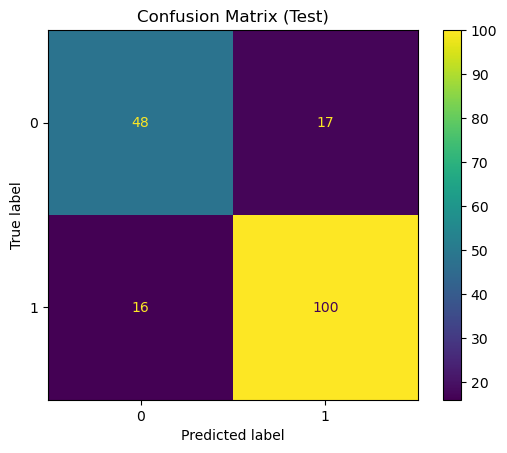

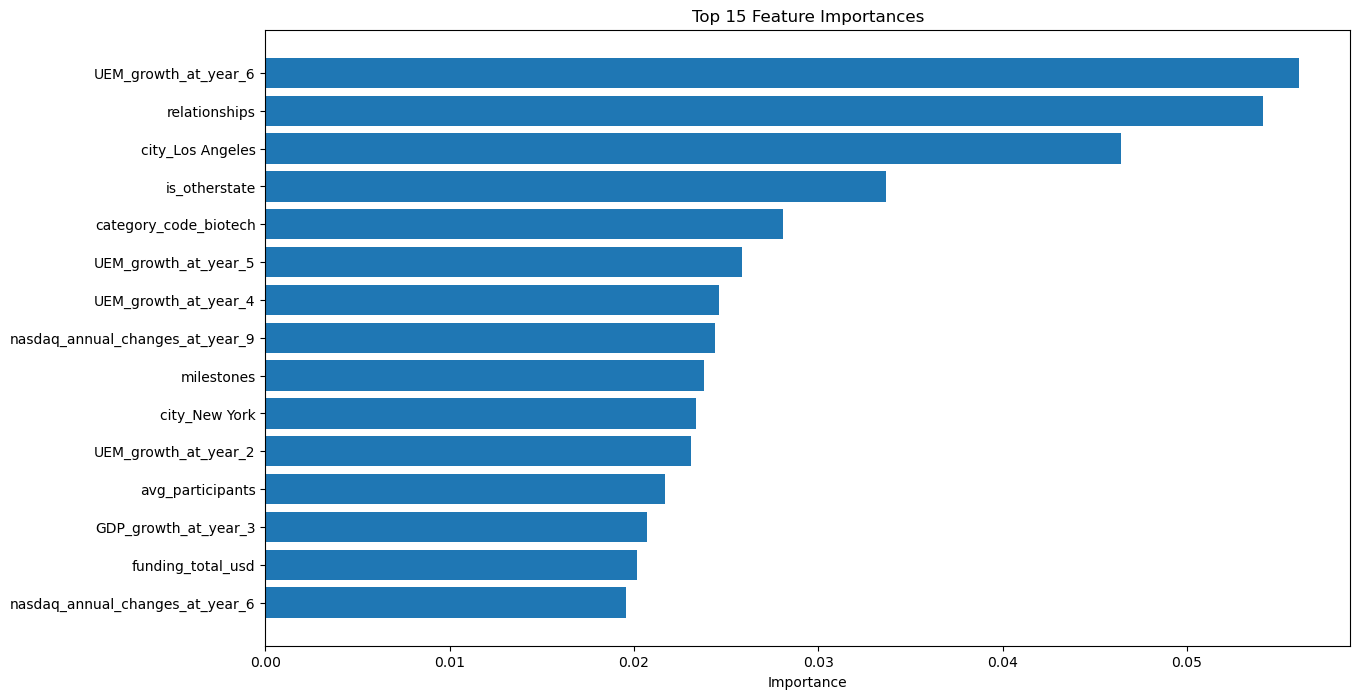

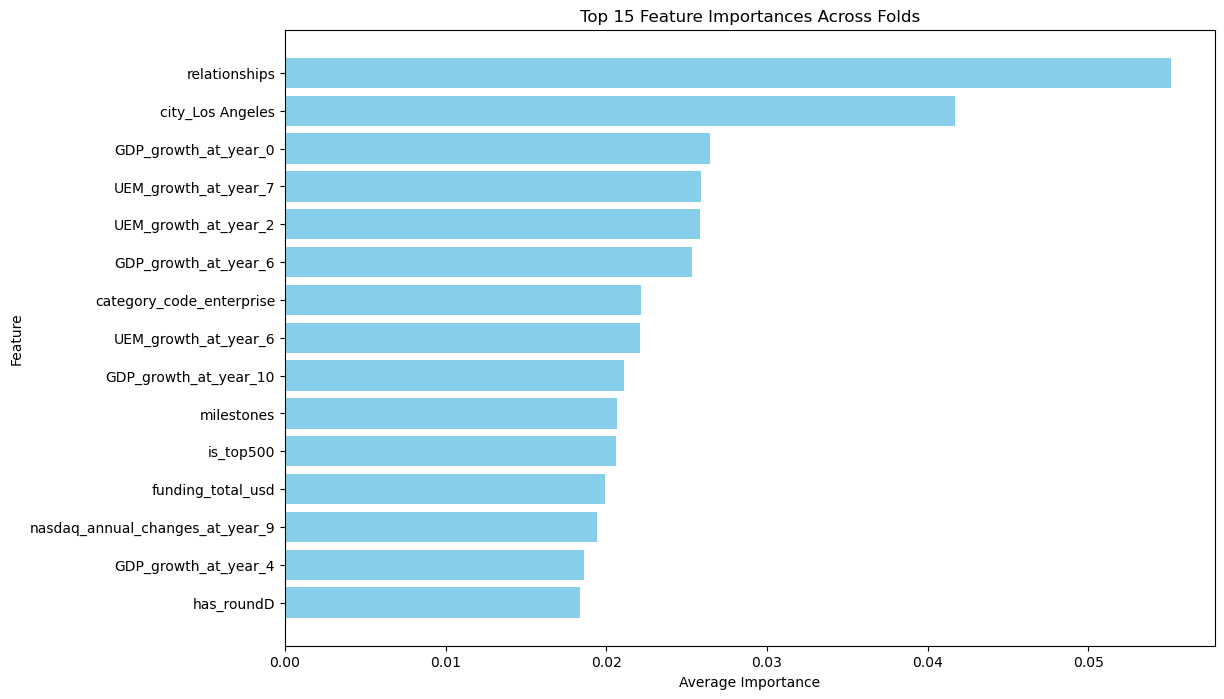

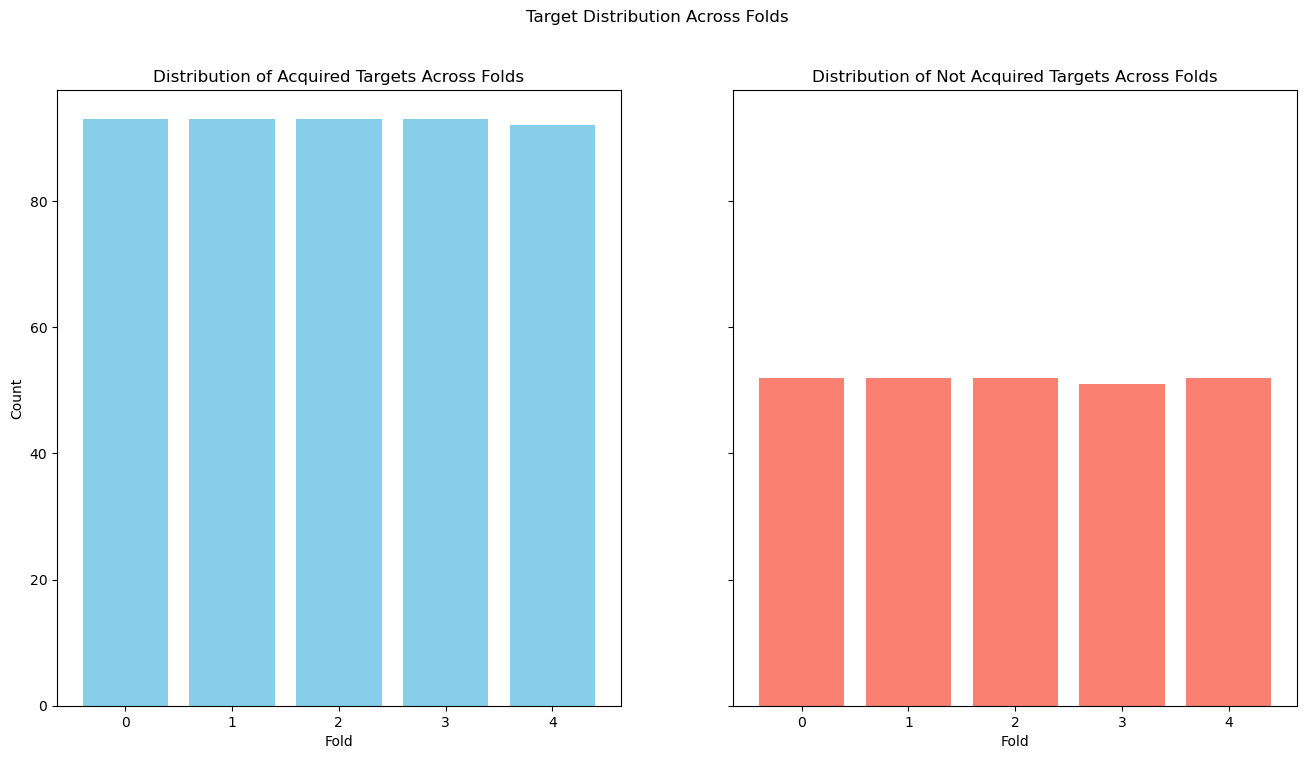

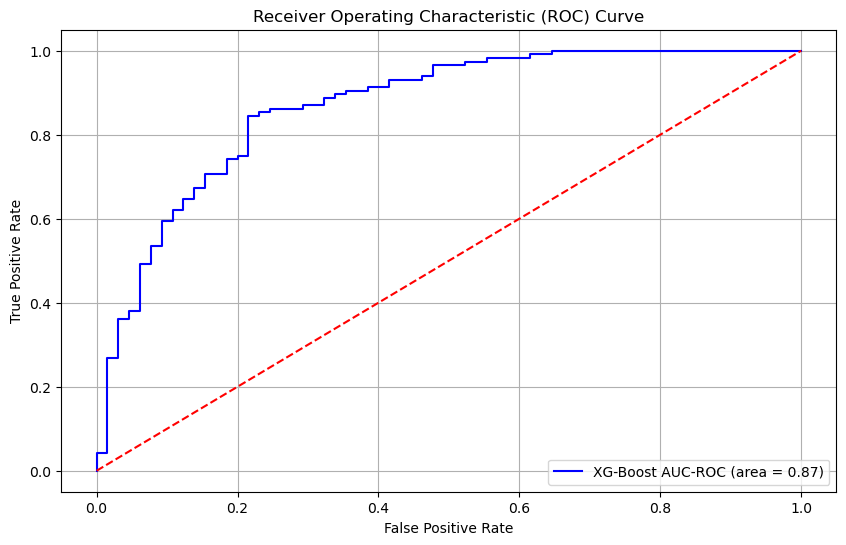

In [17]:
# Initialize your XGBoost model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Perform cross-validation
cv_results_xgb = cross_validate_model_using_StratifiedKFold(xgb_clf, X_train, y_train, n_splits=5, random_state=random_state)

# Train the final model on the entire training data
xgb_clf.fit(X_train, y_train)

# Predict on the test set
xgb_pred, xgb_prob = predict_model(xgb_clf, X_test)
metrics['XGBoost'] = evaluate_model(y_test, xgb_pred, xgb_prob, threshold=0.5)
metrics['XGBoost']['Kappa'] = round(cv_results_xgb['mean_kappa'], 2)

# Plot feature importances
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=15)
feature_names = X_train.columns.tolist()  # Extract feature names
plot_feature_importances_kfold_agg(cv_results_xgb['feature_importances'], feature_names, n_features=15)
plot_target_distribution(cv_results_xgb['fold_targets'])

# Plot AUC-ROC curve
plot_auc_roc_curve(y_test, xgb_prob, model_name='XG-Boost')

In [18]:
# xgb_clf = train_xgb_model(X_train, y_train)
# xgb_pred, xgb_prob = predict_model(xgb_clf, X_test)
# metrics['XGBoost'] = evaluate_model(y_test, xgb_pred, xgb_prob, threshold=0.5)

# cv_results_xgb = perform_cross_validation(xgb_clf, X_train, y_train, n_splits=5, random_state=random_state)
# metrics['XGBoost']['Kappa'] = round(cv_results_xgb['test_kappa'].mean(), 2)

# plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
# plot_auc_roc_curve(y_test, xgb_prob, model_name='XG-Boost')

## Random Forest

Fold 0: Number of 'city_Los Angeles' in validation set: 5.0
Fold 0: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 1: Number of 'city_Los Angeles' in validation set: 2.0
Fold 1: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 2: Number of 'city_Los Angeles' in validation set: 1.0
Fold 2: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 3: Number of 'city_Los Angeles' in validation set: 2.0
Fold 3: Total size of val set is: 144
no duplicates in training indeces within the folds
Fold 4: Number of 'city_Los Angeles' in validation set: 3.0
Fold 4: Total size of val set is: 144
no duplicates in training indeces within the folds
Threshold: 0.5
AUC-ROC: 0.87
Accuracy: 0.81
Balanced Accuracy: 0.77
Precision (Test): 0.8106060606060606
Recall (Test): 0.9224137931034483
              precision    recall  f1-score   support

           0       0.82      0.62      0.70        65
       

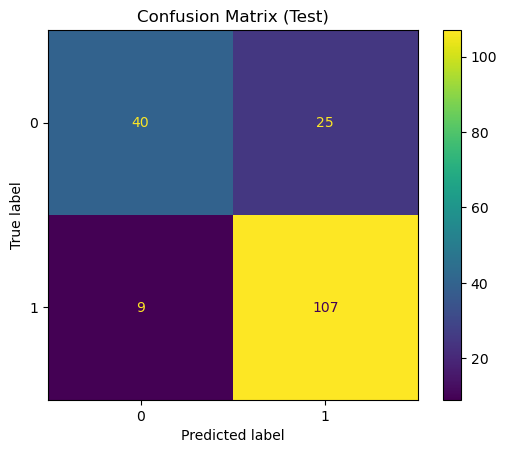

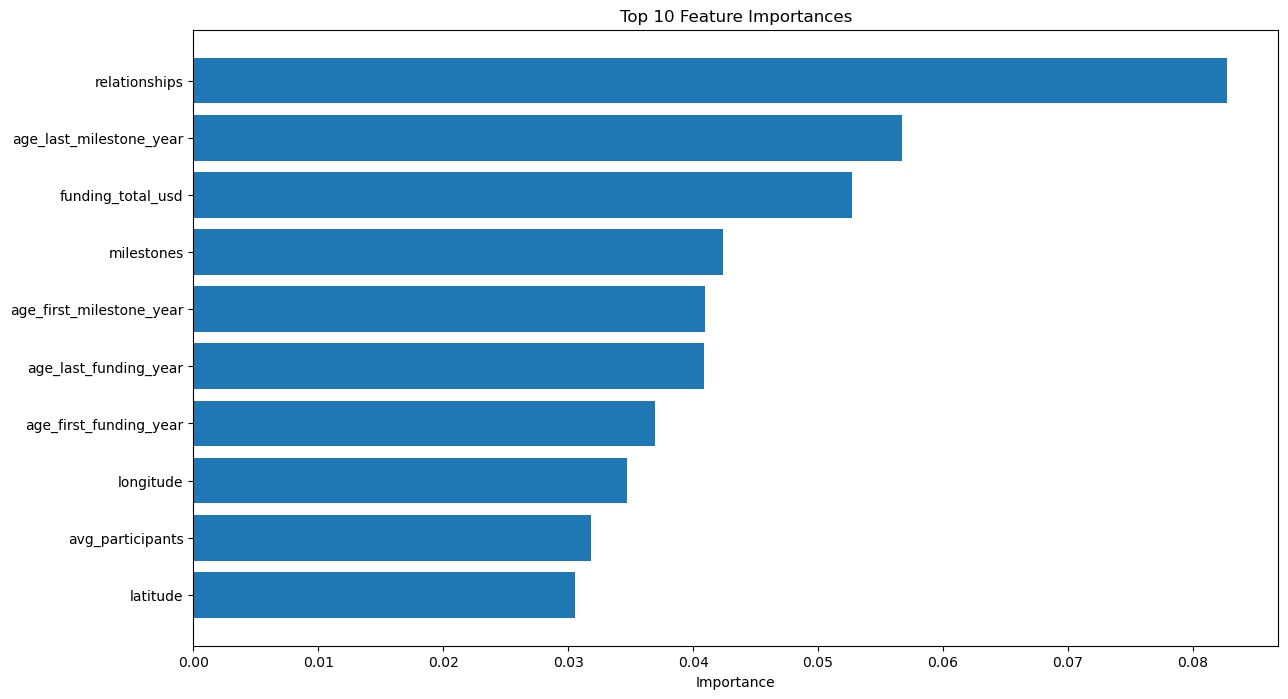

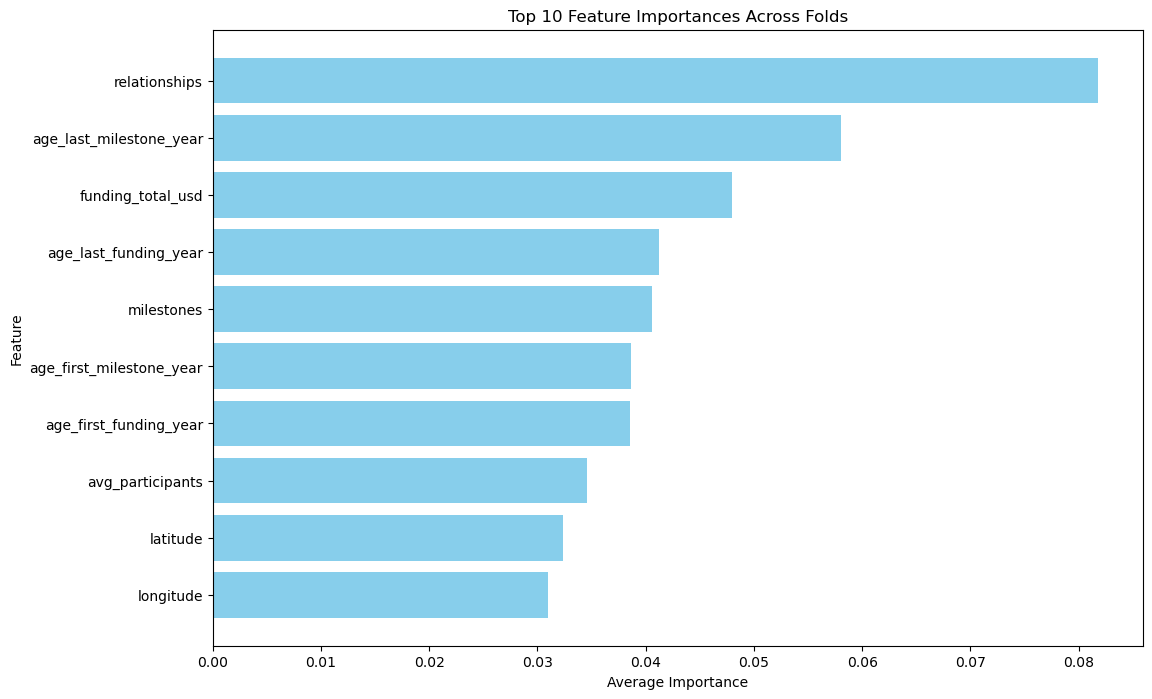

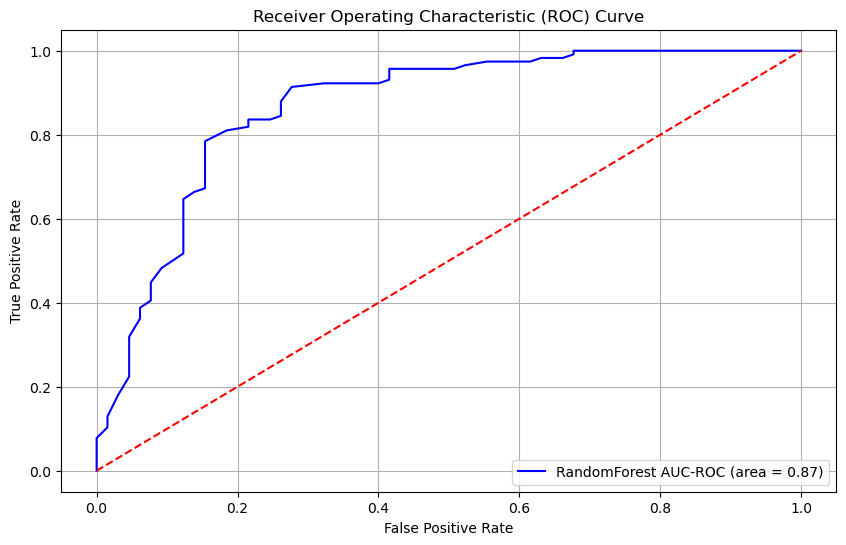

In [19]:
# Initialize your XGBoost model
rf_clf = RandomForestClassifier()

# Perform cross-validation
cv_results_rf = cross_validate_model_using_StratifiedKFold(rf_clf, X_train, y_train, n_splits=5, random_state=random_state)

# Train the final model on the entire training data
rf_clf.fit(X_train, y_train)

# Predict on the test set
rf_pred, rf_prob = predict_model(rf_clf, X_test)
metrics['RandomForest'] = evaluate_model(y_test, rf_pred, rf_prob, threshold=0.5)
metrics['RandomForest']['Kappa'] = round(cv_results_rf['mean_kappa'], 2)

# Plot feature importances
plot_feature_importances(rf_clf, feature_names=X.columns, num_of_features=10)
plot_feature_importances_kfold_agg(cv_results_rf['feature_importances'], feature_names)

# Plot AUC-ROC curve
plot_auc_roc_curve(y_test, rf_prob, model_name='RandomForest')

In [20]:
# rf_clf = train_rf_model(X_train, y_train)
# rf_pred, rf_prob = predict_model(rf_clf, X_test)
# metrics['RandomForest'] = evaluate_model(y_test, rf_pred, rf_prob)

# cv_results_rf = perform_cross_validation(rf_clf, X_train, y_train, n_splits=5, random_state=random_state)
# metrics['RandomForest']['Kappa'] = round(cv_results_rf['test_kappa'].mean(), 2)
# import warnings
# warnings.filterwarnings("ignore")
# plot_feature_importances(rf_clf, feature_names=X.columns, num_of_features=10)
# plot_auc_roc_curve(y_test, rf_prob, model_name='randomForest')

## SVM

Fold 0: Number of 'city_Los Angeles' in validation set: 5.0
Fold 0: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 1: Number of 'city_Los Angeles' in validation set: 2.0
Fold 1: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 2: Number of 'city_Los Angeles' in validation set: 1.0
Fold 2: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 3: Number of 'city_Los Angeles' in validation set: 2.0
Fold 3: Total size of val set is: 144
no duplicates in training indeces within the folds
Fold 4: Number of 'city_Los Angeles' in validation set: 3.0
Fold 4: Total size of val set is: 144
no duplicates in training indeces within the folds
Threshold: 0.5
AUC-ROC: 0.85
Accuracy: 0.78
Balanced Accuracy: 0.72
Precision (Test): 0.7714285714285715
Recall (Test): 0.9310344827586207
              precision    recall  f1-score   support

           0       0.80      0.51      0.62        65
       

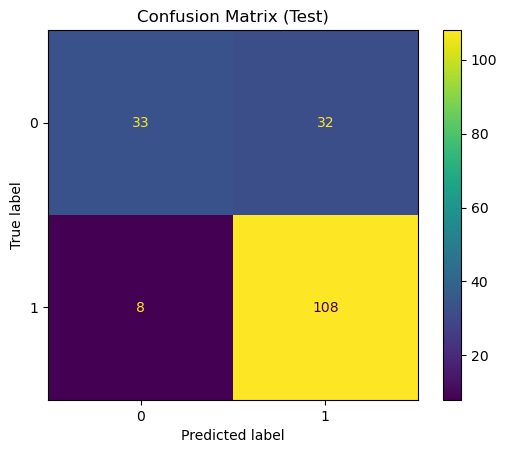

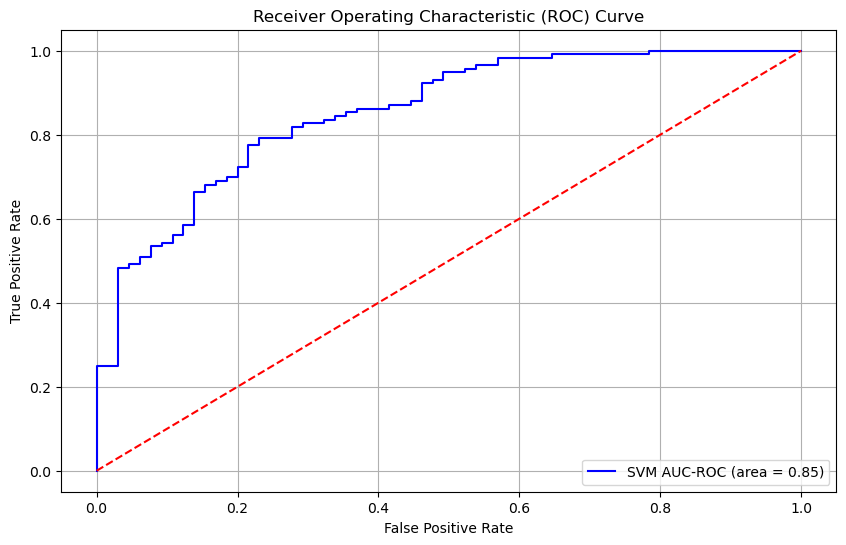

In [21]:
# # Initialize your XGBoost model
svm_clf = SVC(probability=True)

# Perform cross-validation
cv_results_svm = cross_validate_model_using_StratifiedKFold(svm_clf, X_train, y_train, n_splits=5, random_state=random_state, save_feature_impact_across_folds=False)

# Train the final model on the entire training data
svm_clf.fit(X_train, y_train)

# Predict on the test set
svm_pred, svm_prob = predict_model(svm_clf, X_test)
metrics['SVM'] = evaluate_model(y_test, svm_pred, svm_prob, threshold=0.5)
metrics['SVM']['Kappa'] = round(cv_results_svm['mean_kappa'], 2)

# Plot AUC-ROC curve
plot_auc_roc_curve(y_test, svm_prob, model_name='SVM')

In [22]:
# svm_clf = train_svm_model(X_train, y_train)
# svm_pred, svm_prob = predict_model(svm_clf, X_test)
# metrics['SVM'] = evaluate_model(y_test, svm_pred, svm_prob)

# cv_results_SVM = perform_cross_validation(svm_clf, X_train, y_train, n_splits=5, random_state=random_state)
# metrics['SVM']['Kappa'] = round(cv_results_SVM['test_kappa'].mean(), 2)

# plot_auc_roc_curve(y_test, svm_prob, model_name='SVM')

## DecisionTree

Fold 0: Number of 'city_Los Angeles' in validation set: 5.0
Fold 0: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 1: Number of 'city_Los Angeles' in validation set: 2.0
Fold 1: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 2: Number of 'city_Los Angeles' in validation set: 1.0
Fold 2: Total size of val set is: 145
no duplicates in training indeces within the folds
Fold 3: Number of 'city_Los Angeles' in validation set: 2.0
Fold 3: Total size of val set is: 144
no duplicates in training indeces within the folds
Fold 4: Number of 'city_Los Angeles' in validation set: 3.0
Fold 4: Total size of val set is: 144
no duplicates in training indeces within the folds
Threshold: 0.5
AUC-ROC: 0.66
Accuracy: 0.68
Balanced Accuracy: 0.66
Precision (Test): 0.7589285714285714
Recall (Test): 0.7327586206896551
              precision    recall  f1-score   support

           0       0.55      0.58      0.57        65
       

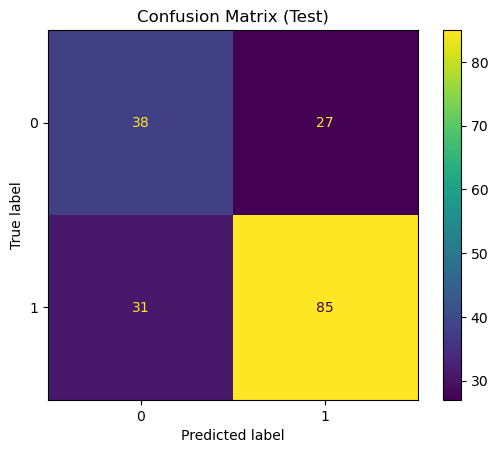

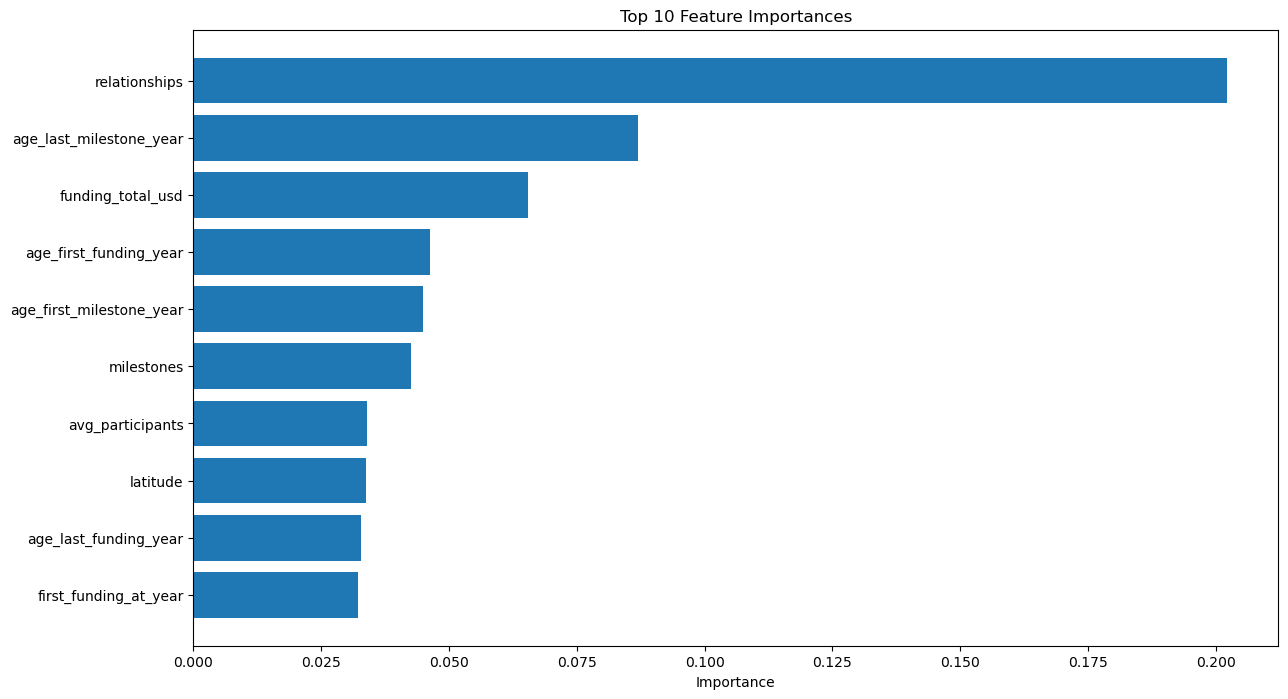

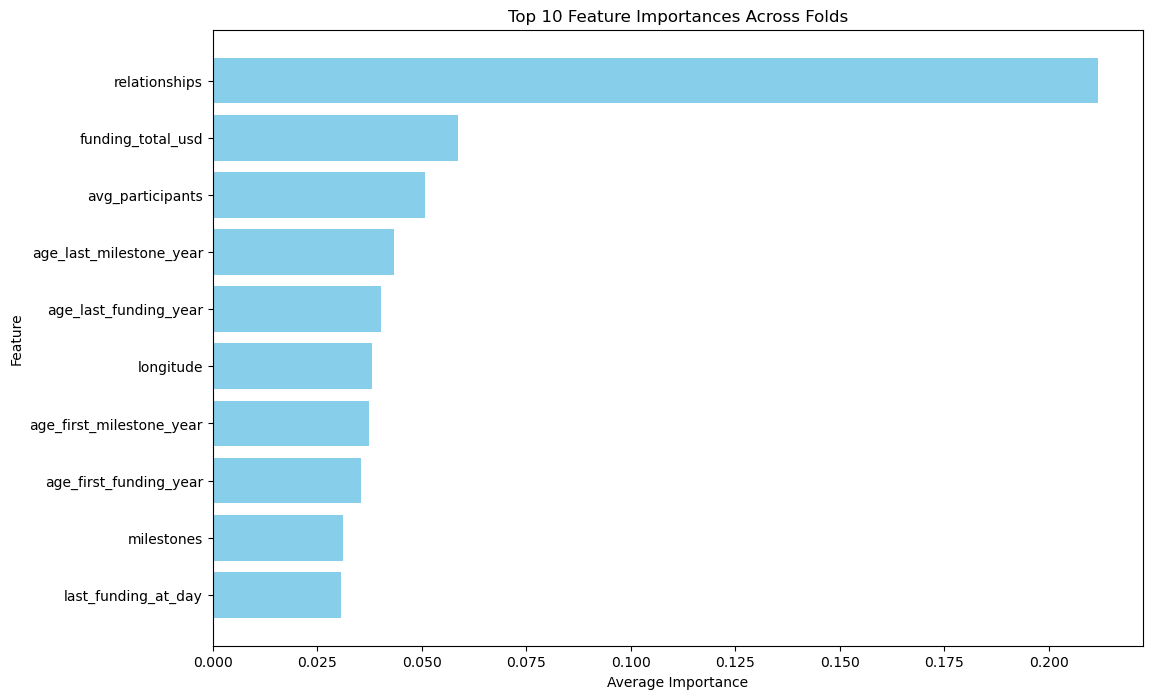

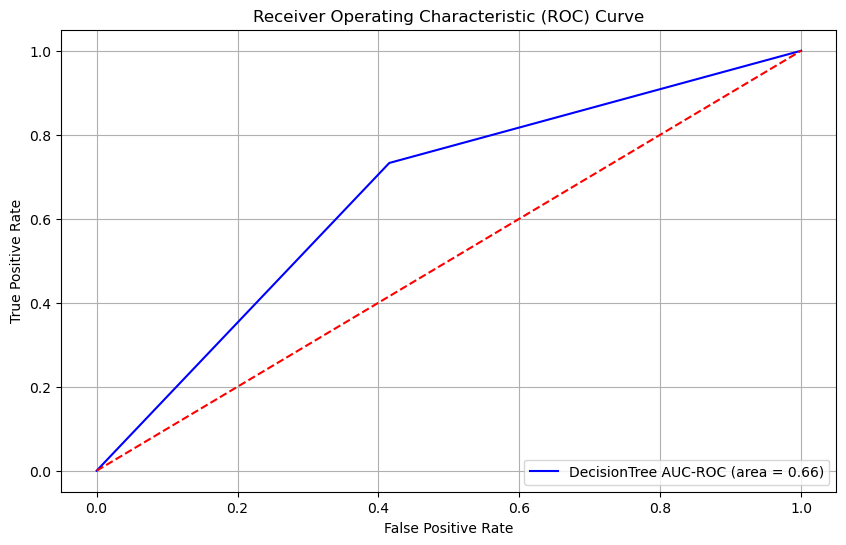

In [23]:
# Initialize your XGBoost model
dt_clf = DecisionTreeClassifier(random_state=42)

# Perform cross-validation
cv_results_dt = cross_validate_model_using_StratifiedKFold(dt_clf, X_train, y_train, n_splits=5, random_state=random_state)

# If needed, you can also use cv_results_xgb['all_preds'], cv_results_xgb['all_probs'], and cv_results_xgb['all_y_true']
# for additional analysis or plotting

# Train the final model on the entire training data
dt_clf.fit(X_train, y_train)

# Predict on the test set
dt_pred, dt_prob = predict_model(dt_clf, X_test)
metrics['DecisionTree'] = evaluate_model(y_test, dt_pred, dt_prob, threshold=0.5)
metrics['DecisionTree']['Kappa'] = round(cv_results_dt['mean_kappa'], 2)

# Plot feature importances
plot_feature_importances(dt_clf, feature_names=X.columns, num_of_features=10)
plot_feature_importances_kfold_agg(cv_results_dt['feature_importances'], feature_names)

# Plot AUC-ROC curve
plot_auc_roc_curve(y_test, dt_prob, model_name='DecisionTree')

In [24]:
# dt_clf = train_decision_tree_model(X_train, y_train)
# dt_pred, dt_prob = predict_model(dt_clf, X_test)
# metrics['DecisionTree'] = evaluate_model(y_test, dt_pred, dt_prob)

# cv_results_dt = perform_cross_validation(dt_clf, X_train, y_train, n_splits=5, random_state=random_state)
# metrics['DecisionTree']['Kappa'] = round(cv_results_dt['test_kappa'].mean(), 2)

# plot_feature_importances(dt_clf, feature_names=X.columns, num_of_features=10)
# plot_auc_roc_curve(y_test, dt_prob, model_name='DecisionTree')

# Ensemble classifiers

## Ensemble all

In [25]:
# # Stack the predictions into a matrix
# predictions = np.vstack((xgb_pred, rf_pred, svm_pred, dt_pred)).T

# # Majority voting
# ensemble_pred, _ = mode(predictions, axis=1)
# ensemble_pred = ensemble_pred.ravel()

# # Combine probabilities (e.g., by averaging them)
# ensemble_prob = (xgb_prob + rf_prob + svm_prob + dt_prob) / 4

# # Evaluate the ensemble model
# evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# # Plot feature importances and AUC-ROC curves
# plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
# plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

## Ensemble selected

Threshold: 0.5
AUC-ROC: 0.87
Accuracy: 0.82
Balanced Accuracy: 0.81
Precision (Test): 0.8620689655172413
Recall (Test): 0.8620689655172413
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        65
           1       0.86      0.86      0.86       116

    accuracy                           0.82       181
   macro avg       0.81      0.81      0.81       181
weighted avg       0.82      0.82      0.82       181

Confusion Matrix (Test):
[[ 49  16]
 [ 16 100]]


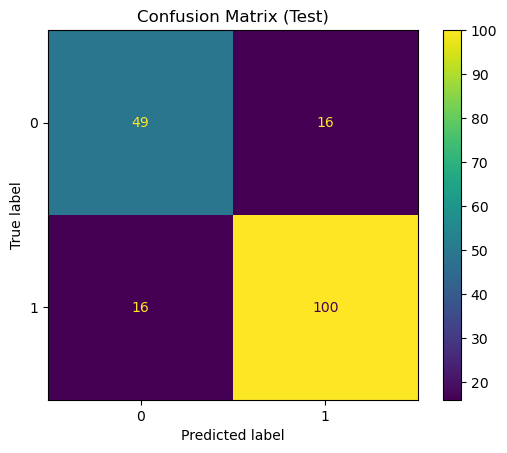

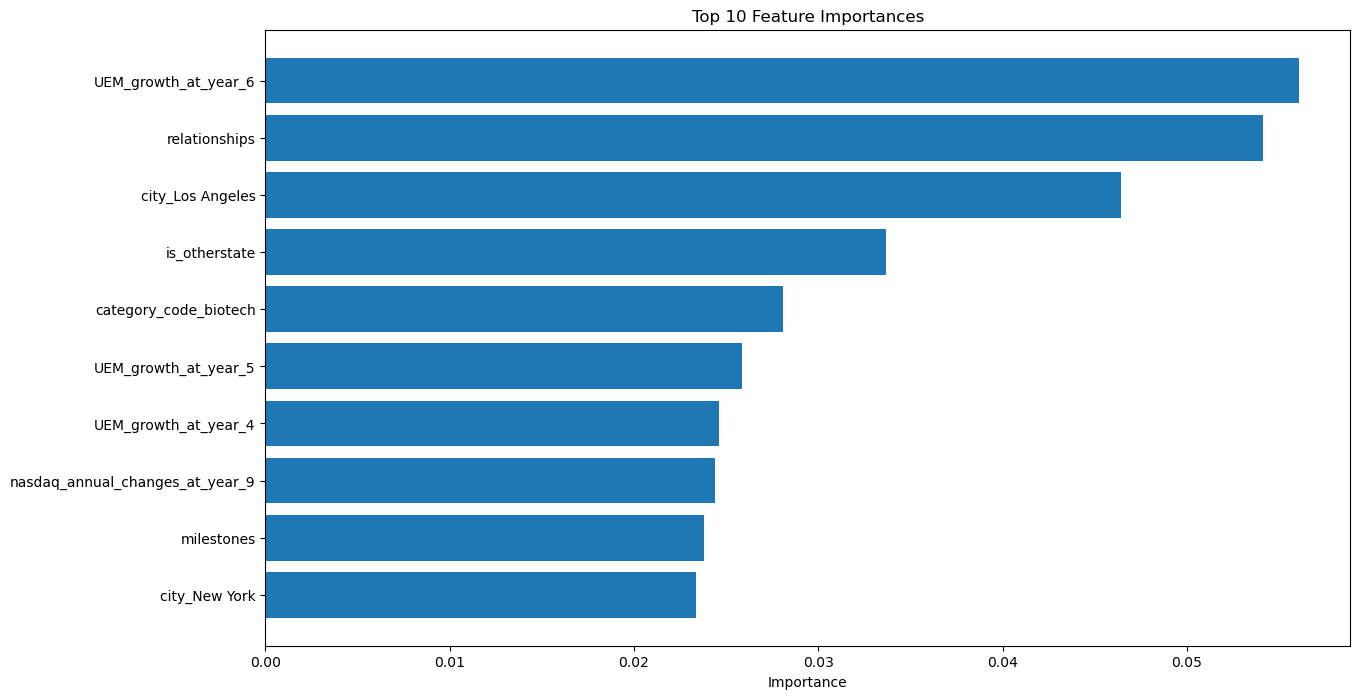

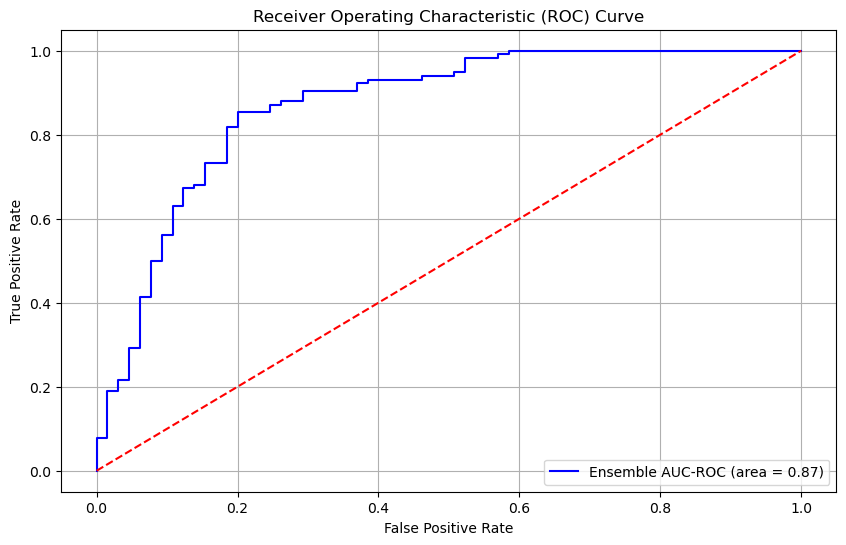

In [26]:
# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rf_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rf_prob) / 2

# Evaluate the ensemble model
metrics['Ensemble'] = evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)

plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

# Analyse classifier results

plot all models results graph

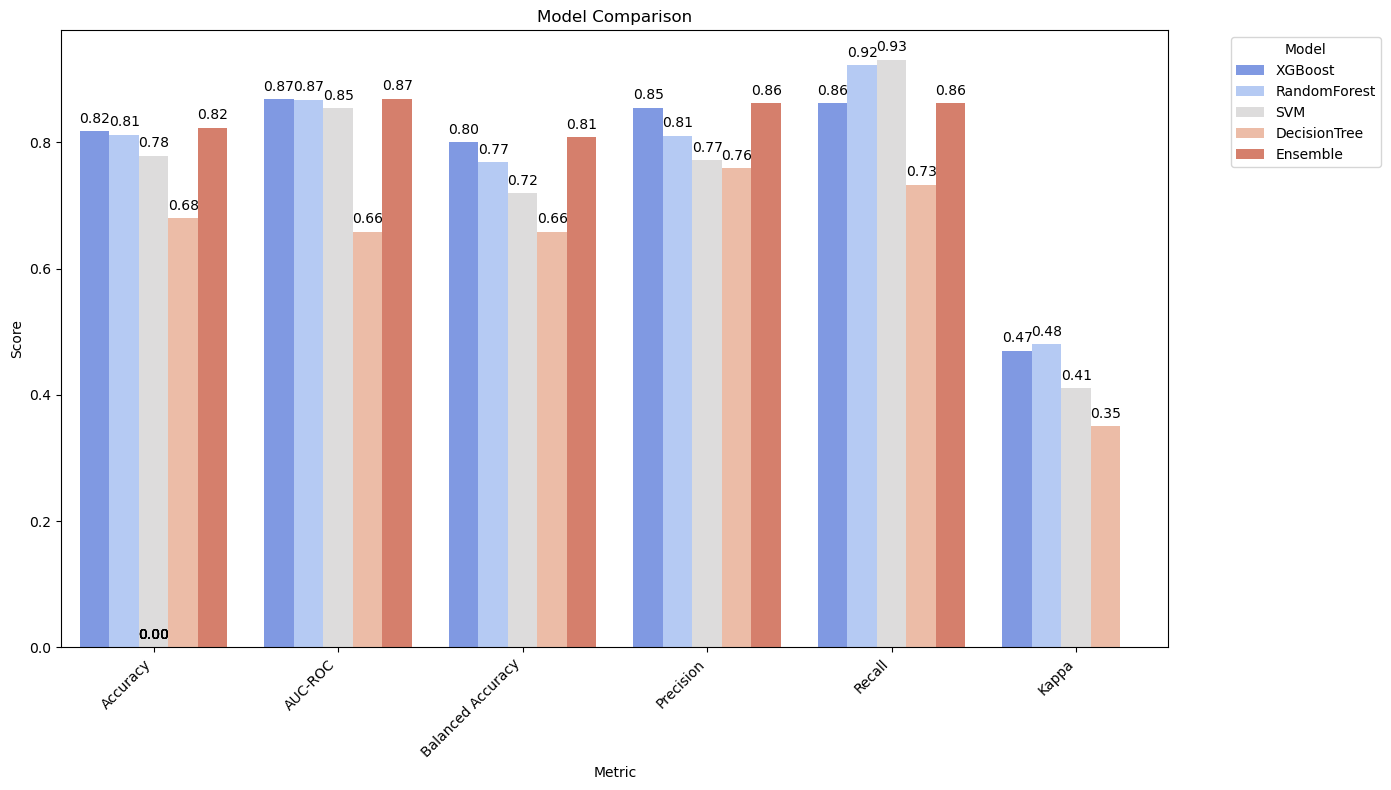

In [27]:
# Define the models
models = ['XGBoost', 'RandomForest', 'SVM', 'DecisionTree', 'Ensemble']
colors = sns.color_palette('coolwarm', n_colors=len(models))

# Create a dictionary to map the model names to the pastel colors
color_mapping = dict(zip(models, colors))

# Convert metrics to DataFrame for plotting
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_df.columns = ['Model', 'Metric', 'Score']

plt.figure(figsize=(14, 8))

# Use seaborn to create the bar plot with the pastel colors
ax = sns.barplot(
    x='Metric', 
    y='Score', 
    hue='Model', 
    data=metrics_df, 
    palette=color_mapping
)

# Add the numbers on top of the bars
for p in ax.patches:    
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Model Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Combine with the original features

In [28]:
import pandas as pd

# Create DataFrame with all features, y_test, and predictions
result_df = pd.DataFrame(X_test, columns=X.columns)
result_df['Actual'] = y_test.values
'''
result_df['Predicted_xgb'] = xgb_pred
result_df['Probability_xgb'] = xgb_prob
result_df['Predicted_rfv2'] = rfv2_pred
result_df['Probability_rfv2'] = rfv2_prob
result_df['Predicted_rf'] = rf_pred
result_df['Probability_rf'] = rf_prob
result_df['Predicted_svm'] = svm_pred
result_df['Probability_svm'] = svm_prob
'''
result_df['Predicted_ensemble'] = ensemble_pred
result_df['Probability_ensemble'] = ensemble_prob

# Display the DataFrame
result_df.head()

,city_Acton,city_Addison,city_Alameda,city_Albuquerque,city_Aliso Viejo,city_Allentown,city_Alpharetta,city_Altamonte Springs,city_Andover,city_Annapolis,...,UEM_growth_at_year_10,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day,Actual,Predicted_ensemble,Probability_ensemble
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.414020,-0.220989,0.806333,-0.926741,-0.065793,-1.462555,1.613193,1,1,0.923486
472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.215126,-1.097192,1.083596,-0.926741,-0.987913,1.099751,0.488415,1,1,0.701278
837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.389681,1.093315,0.529069,1.481521,0.856327,-1.462555,-0.943122,1,1,0.881641
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.674390,1.531416,0.806333,1.782553,1.317387,-1.177855,0.897425,1,1,0.804262
843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.328231,-1.535293,1.638122,1.080144,0.856327,-0.893154,1.817699,1,1,0.924104


## try - drafts

In [29]:
df1 = load_data('../data/startup_data.csv')

In [30]:
result_df_ok = result_df[result_df['Predicted_ensemble'] == result_df['Actual']]
result_df_fail = result_df[result_df['Predicted_ensemble'] != result_df['Actual']]

print(result_df_ok['category_code_biotech'].value_counts() / len(result_df_ok))

category_code_biotech
0.0    0.95302
1.0    0.04698
Name: count, dtype: float64


In [31]:
# Correlation analysis for incorrect predictions, to see which features correlate with the errors, focusing on predicted values
incorrect_corr = (result_df_fail.corr())
print("Correlation in Incorrect Predictions with Predicted Values:\n", incorrect_corr['Predicted_ensemble'].sort_values(ascending=False).head(15))

Correlation in Incorrect Predictions with Predicted Values:
 Predicted_ensemble                 1.000000
Probability_ensemble               0.868993
relationships                      0.549323
nasdaq_annual_changes_at_year_4    0.497603
avg_participants                   0.395739
last_funding_at_year               0.361118
UEM_growth_at_year_0               0.316970
UEM_growth_at_year_6               0.302498
UEM_growth_at_year_1               0.264602
first_funding_at_year              0.262557
longitude                          0.261621
city_Mountain View                 0.258199
category_code_other                0.258199
category_code_mobile               0.258199
milestones                         0.252755
Name: Predicted_ensemble, dtype: float64


In [32]:
# Add a new column 'predicted_correctly' to the DataFrame
result_df['predicted_correctly'] = (result_df['Predicted_ensemble'] == result_df['Actual']).astype(int)

                  Total  Correct  Incorrect  Accuracy
web                31.0     26.0        5.0  0.838710
software           29.0     23.0        6.0  0.793103
enterprise         13.0     12.0        1.0  0.923077
mobile             13.0     11.0        2.0  0.846154
network_hosting    12.0      8.0        4.0  0.666667
games_video        11.0     10.0        1.0  0.909091
advertising        10.0     10.0        0.0  1.000000
hardware            8.0      6.0        2.0  0.750000
biotech             7.0      7.0        0.0  1.000000
cleantech           6.0      5.0        1.0  0.833333
ecommerce           6.0      4.0        2.0  0.666667
semiconductor       5.0      4.0        1.0  0.800000
security            5.0      4.0        1.0  0.800000
other               4.0      2.0        2.0  0.500000
messaging           3.0      3.0        0.0  1.000000
search              3.0      3.0        0.0  1.000000
public_relations    3.0      2.0        1.0  0.666667
music               2.0     

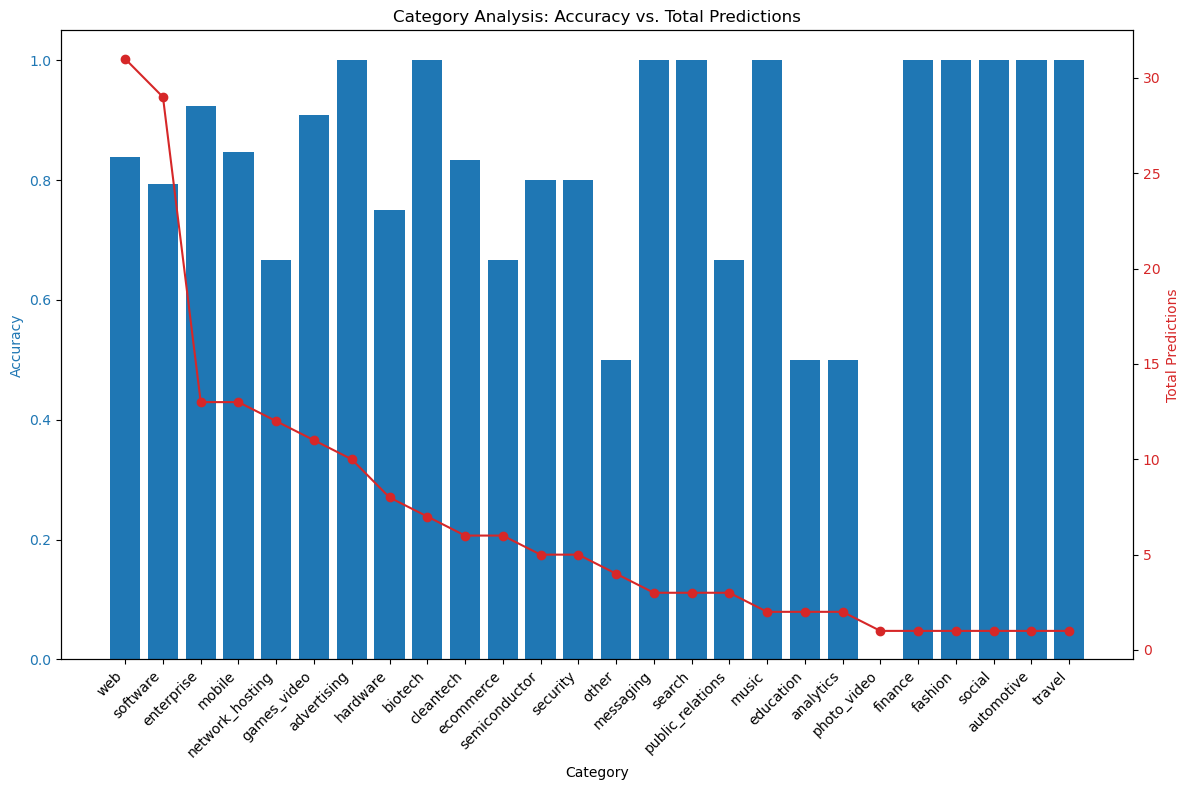

In [33]:
import matplotlib.pyplot as plt

# Calculate the total predictions for each category and the correct prediction rate
category_analysis = {}

for column in result_df.columns:
    if column.startswith('category_code_'):
        total = result_df[column].sum()  # total instances of this category
        correct = result_df[result_df['predicted_correctly'] == 1][column].sum()
        accuracy = correct / total if total > 0 else 0
        incorrect = total - correct
        category_name = column.replace('category_code_', '')
        category_analysis[category_name] = {'Total': total, 'Correct': correct, 'Incorrect': incorrect, 'Accuracy': accuracy}

# Convert to DataFrame for better visualization
category_df = pd.DataFrame.from_dict(category_analysis, orient='index')
category_df = category_df.sort_values(by='Total', ascending=False)

# Filter out categories with total prediction count of 0
category_df = category_df[category_df['Total'] > 0]

print(category_df)

# Plot the accuracy with quantitative information
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Category')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(category_df.index, category_df['Accuracy'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')

# Create a second y-axis for the total counts
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Predictions', color=color)
ax2.plot(category_df.index, category_df['Total'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Category Analysis: Accuracy vs. Total Predictions')
fig.tight_layout()
plt.show()


## The classifier Performance on different categories

                 Total  Correct  Incorrect
web               31.0     26.0        5.0
software          29.0     23.0        6.0
enterprise        13.0     12.0        1.0
mobile            13.0     11.0        2.0
network_hosting   12.0      8.0        4.0
games_video       11.0     10.0        1.0
advertising       10.0     10.0        0.0
hardware           8.0      6.0        2.0
biotech            7.0      7.0        0.0
cleantech          6.0      5.0        1.0
ecommerce          6.0      4.0        2.0


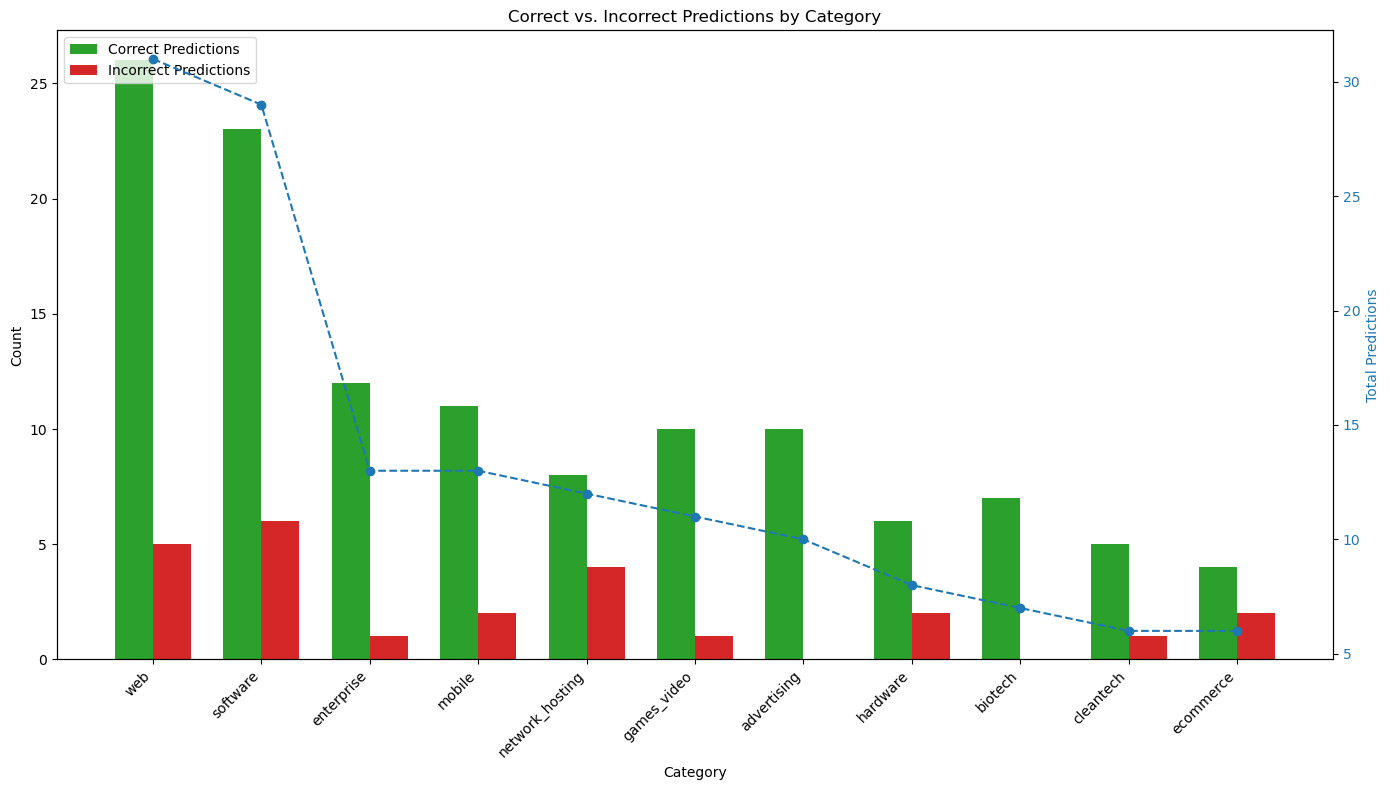

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the total predictions for each category and the correct/incorrect prediction counts
category_analysis = {}

for column in result_df.columns:
    if column.startswith('category_code_'):
        total = result_df[column].sum()  # total instances of this category
        correct = result_df[result_df['predicted_correctly'] == 1][column].sum()
        incorrect = total - correct
        category_name = column.replace('category_code_', '')
        category_analysis[category_name] = {'Total': total, 'Correct': correct, 'Incorrect': incorrect}

# Convert to DataFrame for better visualization
category_df = pd.DataFrame.from_dict(category_analysis, orient='index')
category_df = category_df.sort_values(by='Total', ascending=False)

# Filter out categories with total prediction count <5
category_df = category_df[category_df['Total'] > 5]

print(category_df)

# Plot the correct and incorrect predictions side by side with a secondary y-axis for total predictions
fig, ax1 = plt.subplots(figsize=(14, 8))

bar_width = 0.35
index = np.arange(len(category_df.index))

# Bars for correct predictions
bars1 = ax1.bar(index, category_df['Correct'], bar_width, label='Correct Predictions', color='tab:green')

# Bars for incorrect predictions
bars2 = ax1.bar(index + bar_width, category_df['Incorrect'], bar_width, label='Incorrect Predictions', color='tab:red')

# Primary y-axis
ax1.set_xlabel('Category')
ax1.set_ylabel('Count')
ax1.set_title('Correct vs. Incorrect Predictions by Category')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(category_df.index, rotation=45, ha='right')
ax1.legend(loc='upper left')

# Secondary y-axis for total predictions
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Total Predictions', color=color)
ax2.plot(index + bar_width / 2, category_df['Total'], color=color, marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()
plt.show()


### same for 5-fold results aggregation

/tmp/ipykernel_181134/3742074711.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted'] = ensemble_pred
/tmp/ipykernel_181134/3742074711.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted'] = ensemble_pred
/tmp/ipykernel_181134/3742074711.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

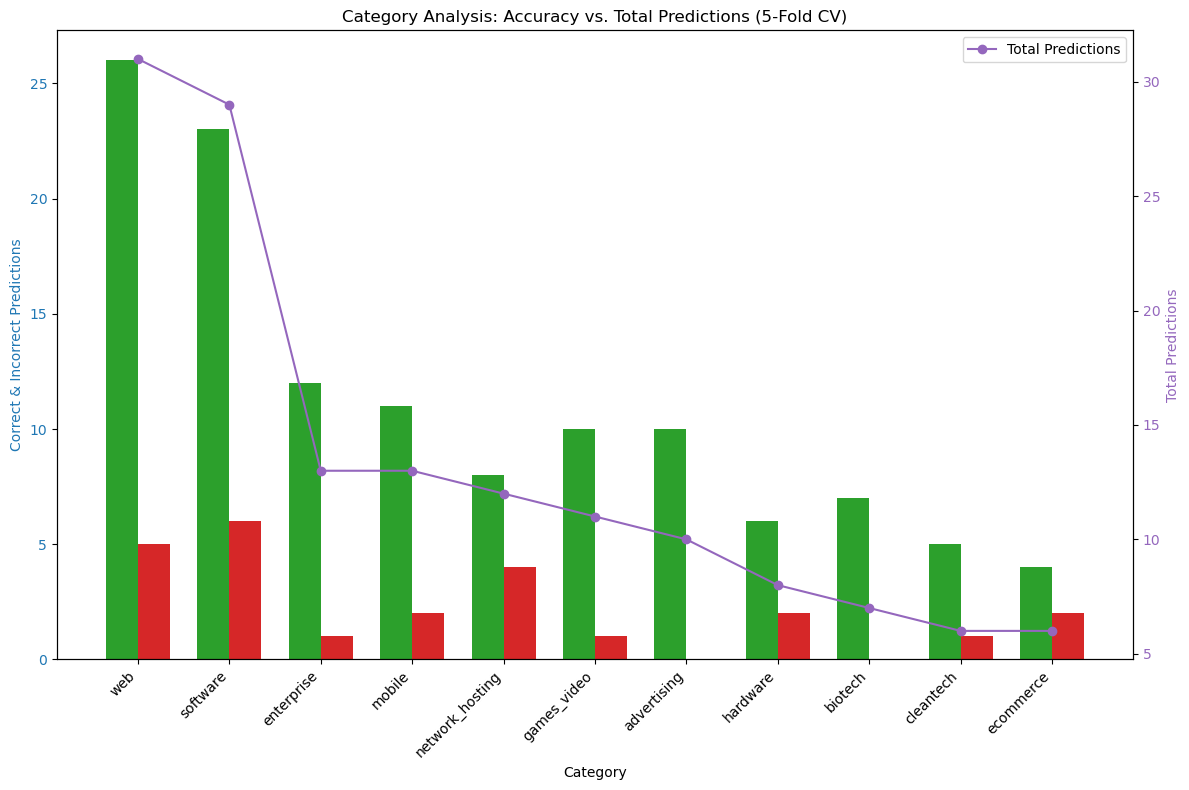

In [35]:
from sklearn.model_selection import KFold
from scipy.stats import mode

# Assuming your result_df has the necessary columns to be used as features
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

category_analysis_cv = []

for train_index, test_index in kf.split(result_df):
    train_df, test_df = result_df.iloc[train_index], result_df.iloc[test_index]

    # Ensure only the original feature columns are used
    feature_columns = X.columns  

    X_train, y_train = train_df[feature_columns], train_df['Actual']
    X_test, y_test = test_df[feature_columns], test_df['Actual']

    # Replace this with your actual model fitting and predicting code
    xgb_pred, xgb_prob = predict_model(xgb_clf, X_test)
    rf_pred, rf_prob = predict_model(rf_clf, X_test)
    # svm_pred, svm_prob = predict_model(svm_clf, X_test)

    # Stack the predictions into a matrix
    predictions = np.vstack((xgb_pred, rf_pred)).T

    # Majority voting
    ensemble_pred, _ = mode(predictions, axis=1)
    ensemble_pred = ensemble_pred.ravel()

    # Store the predicted and actual values in test_df
    test_df['Predicted'] = ensemble_pred

    # Now calculate the statistics for this fold
    for column in result_df.columns:
        if column.startswith('category_code_'):
            total = test_df[column].sum()  # total instances of this category in the fold
            correct = test_df[(test_df['Predicted'] == test_df['Actual'])][column].sum()
            incorrect = total - correct
            accuracy = correct / total if total > 0 else 0
            category_name = column.replace('category_code_', '')
            category_analysis_cv.append({'Category': category_name, 'Total': total, 'Correct': correct, 'Incorrect': incorrect, 'Accuracy': accuracy})

# Aggregate results across folds
category_df_cv = pd.DataFrame(category_analysis_cv)
category_df_cv = category_df_cv.groupby('Category').sum()
category_df_cv['Accuracy'] = category_df_cv['Correct'] / category_df_cv['Total']

# Sort by the most common categories
category_df_cv = category_df_cv.sort_values(by='Total', ascending=False)

# Filter out categories with total prediction count of <5
category_df_cv = category_df_cv[category_df_cv['Total'] > 5]

# Set the width for the bars
bar_width = 0.35

# Plotting Correct vs Incorrect predictions side by side
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Category')
ax1.set_ylabel('Correct & Incorrect Predictions', color=color)

# Set the positions for the bars
index = np.arange(len(category_df_cv))

# Plot the bars side by side
ax1.bar(index - bar_width/2, category_df_cv['Correct'], bar_width, color='tab:green', label='Correct')
ax1.bar(index + bar_width/2, category_df_cv['Incorrect'], bar_width, color='tab:red', label='Incorrect')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(index)
ax1.set_xticklabels(category_df_cv.index, rotation=45, ha='right')

# Create a second y-axis for the total counts
ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Total Predictions', color=color)
ax2.plot(index, category_df_cv['Total'], color=color, marker='o', label='Total Predictions')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Category Analysis: Accuracy vs. Total Predictions (5-Fold CV)')
fig.tight_layout()
plt.legend()
plt.show()



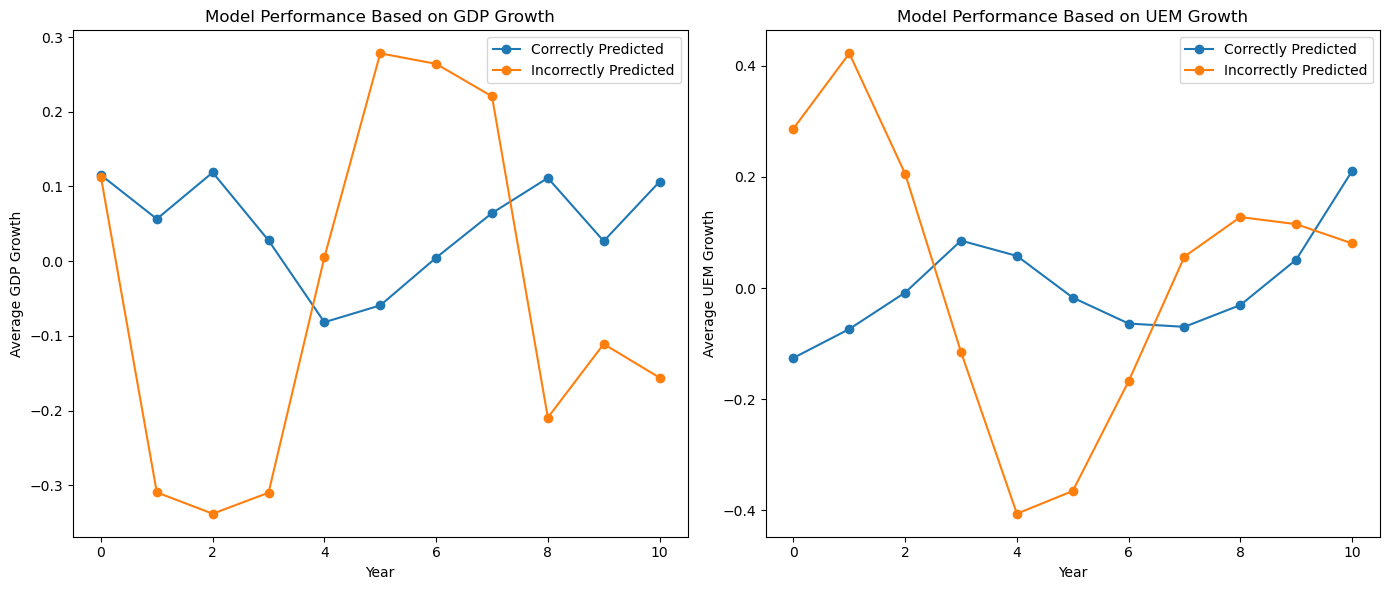

In [36]:
# Extract GDP and UEM columns
gdp_columns = [col for col in result_df.columns if 'GDP_growth_at_year' in col]
uem_columns = [col for col in result_df.columns if 'UEM_growth_at_year' in col]

# Calculate mean prediction correctness for each year
gdp_accuracy = result_df.groupby('predicted_correctly')[gdp_columns].mean().T
uem_accuracy = result_df.groupby('predicted_correctly')[uem_columns].mean().T

# Assign a vector of 0-10 to the 'Year' column
gdp_accuracy['Year'] = list(range(11))
uem_accuracy['Year'] = list(range(11))

# Plotting the results
plt.figure(figsize=(14, 6))

# GDP Growth plot
plt.subplot(1, 2, 1)
plt.plot(gdp_accuracy['Year'], gdp_accuracy[1], label='Correctly Predicted', marker='o')
plt.plot(gdp_accuracy['Year'], gdp_accuracy[0], label='Incorrectly Predicted', marker='o')
plt.xlabel('Year')
plt.ylabel('Average GDP Growth')
plt.title('Model Performance Based on GDP Growth')
plt.legend()

# UEM Growth plot
plt.subplot(1, 2, 2)
plt.plot(uem_accuracy['Year'], uem_accuracy[1], label='Correctly Predicted', marker='o')
plt.plot(uem_accuracy['Year'], uem_accuracy[0], label='Incorrectly Predicted', marker='o')
plt.xlabel('Year')
plt.ylabel('Average UEM Growth')
plt.title('Model Performance Based on UEM Growth')
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(14, 5))

# # Plot distribution for relationships on the left
# plt.subplot(1, 2, 1)
# sns.kdeplot(correct_original_df['relationships'], shade=True, label='Correct', color='g')
# sns.kdeplot(incorrect_original_df['relationships'], shade=True, label='Incorrect', color='r')
# plt.title('Distribution of "relationships"')
# plt.legend()

# # Plot distribution for founded_at_year on the right
# plt.subplot(1, 2, 2)
# sns.kdeplot(correct_original_df['founded_at_year'], shade=True, label='Correct', color='g')
# sns.kdeplot(incorrect_original_df['founded_at_year'], shade=True, label='Incorrect', color='r')
# plt.title('Distribution of "founded_at_year"')
# plt.legend()

# # Add a big title to the entire figure
# plt.suptitle('High effect Feature Distributions for Correct and Incorrect Predictions', fontsize=16, y=1.05)

# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()

In [38]:
df1.category_code.value_counts()

category_code
software            153
web                 144
mobile               79
enterprise           73
advertising          62
games_video          52
semiconductor        35
network_hosting      34
biotech              34
hardware             27
ecommerce            25
public_relations     25
cleantech            23
security             19
analytics            19
social               14
search               12
other                11
messaging            11
fashion               8
travel                8
news                  8
medical               7
photo_video           7
music                 6
finance               6
education             4
consulting            3
real_estate           3
health                3
automotive            2
manufacturing         2
transportation        2
hospitality           1
sports                1
Name: count, dtype: int64

In [39]:
result_df_fail['category_code_biotech'] = result_df_fail.category_code_biotech.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_biotech'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_biotech'].value_counts() )

category_code_biotech
0    32
Name: count, dtype: int64


/tmp/ipykernel_181134/3361802483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_fail['category_code_biotech'] = result_df_fail.category_code_biotech.apply(lambda x: 1 if x > 0.6 else 0)


In [40]:
result_df_fail['category_code_software'] = result_df_fail.category_code_software.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_software'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_software'].value_counts() )

category_code_software
0    26
1     6
Name: count, dtype: int64


/tmp/ipykernel_181134/3962302272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_fail['category_code_software'] = result_df_fail.category_code_software.apply(lambda x: 1 if x > 0.6 else 0)


In [41]:
result_df_fail['category_code_other'] = result_df_fail.category_code_other.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['is_othercategory'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_other'].value_counts() )

category_code_other
0    30
1     2
Name: count, dtype: int64


/tmp/ipykernel_181134/1649161994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_fail['category_code_other'] = result_df_fail.category_code_other.apply(lambda x: 1 if x > 0.6 else 0)


In [42]:
# # Create label
df['status_code'] = df['status'].map({'acquired': 1, 'closed': 0})
print_correlations_Spearman_and_Pearson(df['GDP_growth_at_year_0'], df['status_code'])
print_correlations_Spearman_and_Pearson(df['relationships'], df['status_code'])
print_correlations_Spearman_and_Pearson(df['avg_participants'], df['status_code'])
print_correlations_Spearman_and_Pearson(df['has_roundC'], df['status_code'])
print_correlations_Spearman_and_Pearson(df['has_roundD'], df['status_code'])

Spearman correlation: -0.02395745272281034, p-value: 0.4672459574613621
Pearson correlation: -0.044394064377681786, p-value: 0.17779704682205782
Spearman correlation: 0.466947609250253, p-value: 3.63257569528578e-51
Pearson correlation: 0.3604336437709972, p-value: 1.0678742927713986e-29
Spearman correlation: 0.226498446014084, p-value: 3.3408410636154857e-12
Pearson correlation: 0.18599162866024185, p-value: 1.2506004126542012e-08
Spearman correlation: 0.1659015104590796, p-value: 4.008095143462745e-07
Pearson correlation: 0.1659015104590796, p-value: 4.0080951434626525e-07
Spearman correlation: 0.13994040612339836, p-value: 1.9832511468107988e-05
Pearson correlation: 0.13994040612339836, p-value: 1.9832511468109062e-05


In [43]:
result_df.category_code_other.value_counts()

category_code_other
0.0    177
1.0      4
Name: count, dtype: int64

# Regressors

In [44]:
'''
'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate',
'category_code', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory',
'has_roundB', 'has_roundC', 'has_roundD', 'has_VC', 'has_angel', 'has_roundA',
'''
'''
'closed_at', 'age_first_funding_year', 'age_last_funding_year',
'age_first_milestone_year', 'age_last_milestone_year', 'funding_rounds', 'funding_total_usd',
'milestones', 'avg_participants',
'''

"\n'closed_at', 'age_first_funding_year', 'age_last_funding_year',\n'age_first_milestone_year', 'age_last_milestone_year', 'funding_rounds', 'funding_total_usd',\n'milestones', 'avg_participants',\n"

## predict age_first_funding_year

Mean Squared Error (MSE): 0.41
Mean Absolute Error (MAE): 0.39
R-squared (R²): 0.9
Custom Accuracy (within ±10%): 73.51%


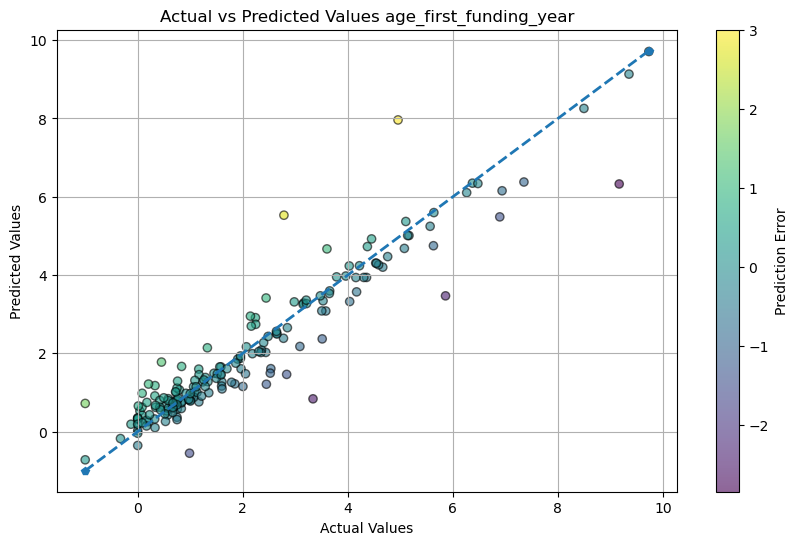

<Figure size 1000x800 with 0 Axes>

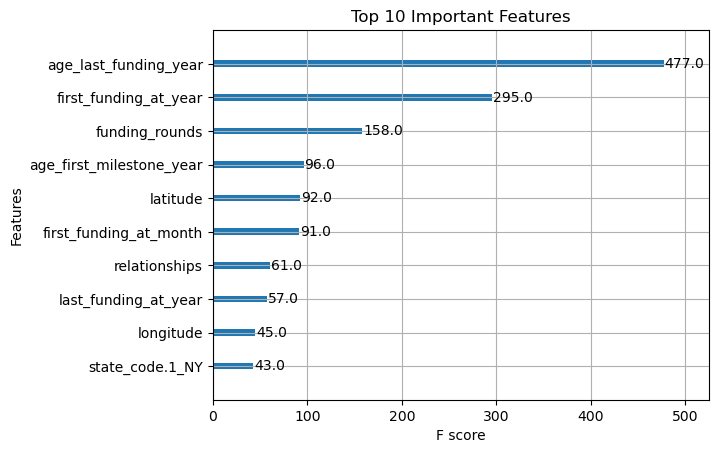

Custom Accuracy within 1 year: 87.57%


In [45]:
# Create target
y = df['age_first_funding_year']
df1 = df.drop('age_first_funding_year', axis=1)
# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_first_funding_year', tolerance = 0.4)

accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Custom Accuracy within {1} year: {accuracy_abs * 100:.2f}%")

## age_last_funding_year

Mean Squared Error (MSE): 0.31
Mean Absolute Error (MAE): 0.4
R-squared (R²): 0.95
Custom Accuracy (within ±10%): 88.11%


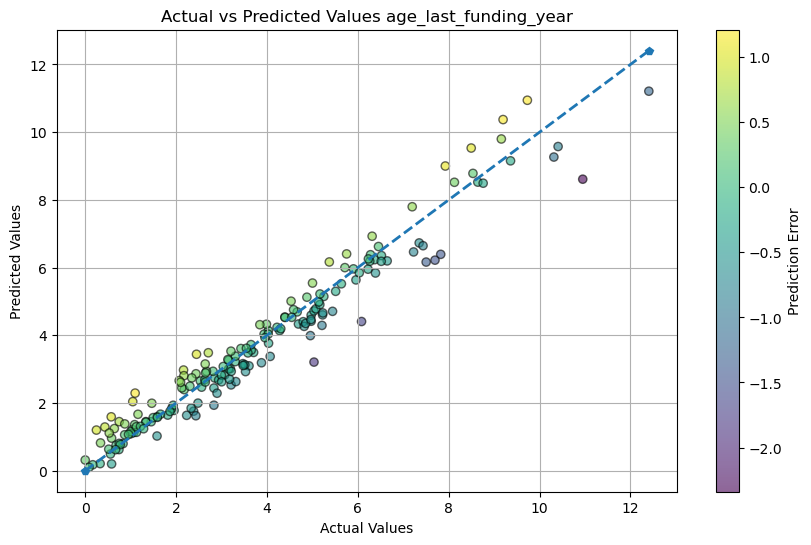

<Figure size 1000x800 with 0 Axes>

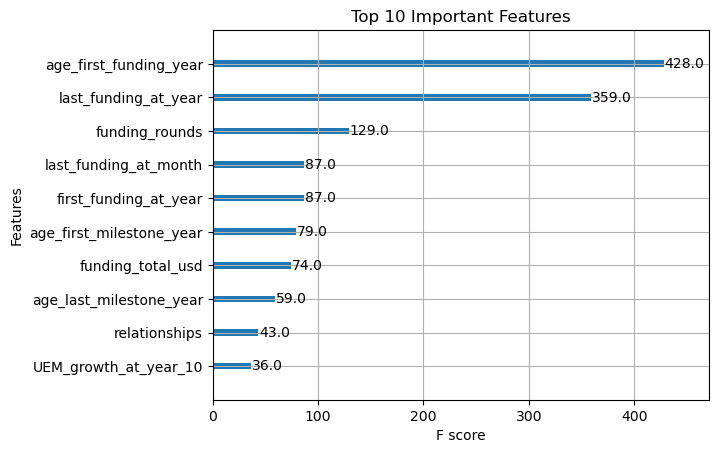

Accuracy within 1 year: 96.22%


In [46]:
# Create target
y = df['age_last_funding_year']
df1 = df.drop('age_last_funding_year', axis=1)
# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_last_funding_year', tolerance = 0.3)
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} year: {accuracy_abs * 100:.2f}%")

## funding_rounds

771
Mean Squared Error (MSE): 2.35
Mean Absolute Error (MAE): 0.96
R-squared (R²): 0.7
Custom Accuracy (within ±10%): 55.48%


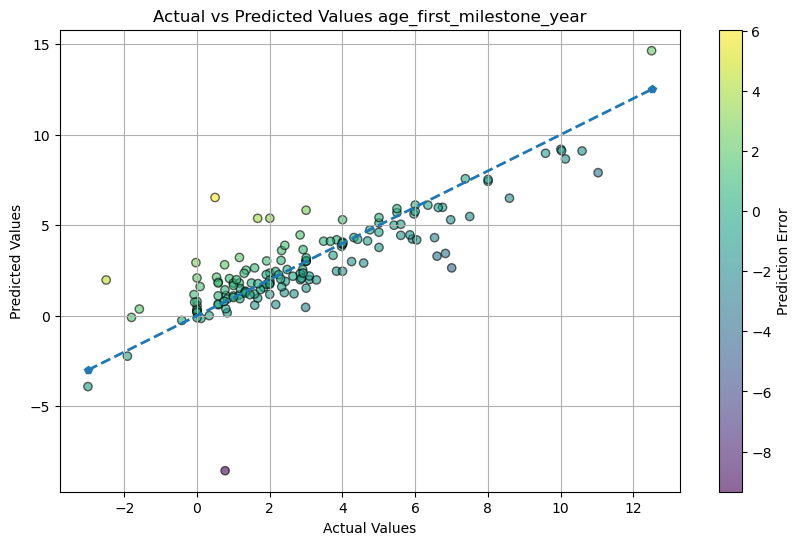

<Figure size 1000x800 with 0 Axes>

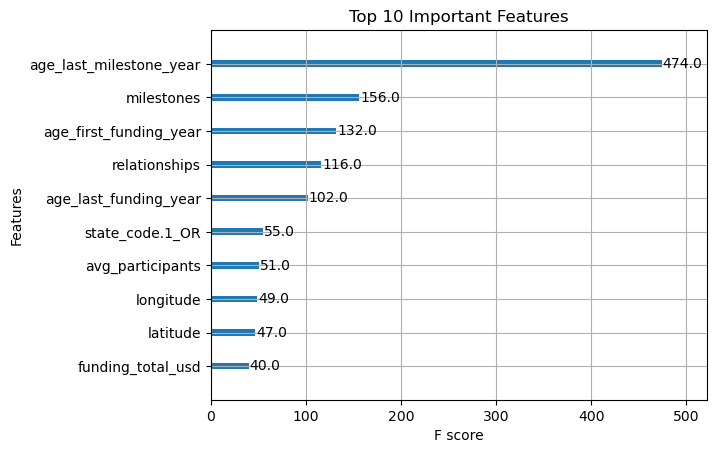

Accuracy within 1 round: 83.23%


In [47]:
# Create target
df1 = df.copy()

# Drop rows where 'age_first_milestone_year' is NaN
df1.dropna(subset=['age_first_milestone_year'], inplace=True)
print(len(df1))
y = df1['age_first_milestone_year']
df1 = df1.drop('age_first_milestone_year', axis=1)
# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'age_first_milestone_year', tolerance = 0.3)
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} round: {accuracy_abs * 100:.2f}%")

## funding_total_usd

Mean Squared Error (MSE): 1688192122066178.5
Mean Absolute Error (MAE): 12889594.28
R-squared (R²): 0.05
Custom Accuracy (within ±10%): 37.30%


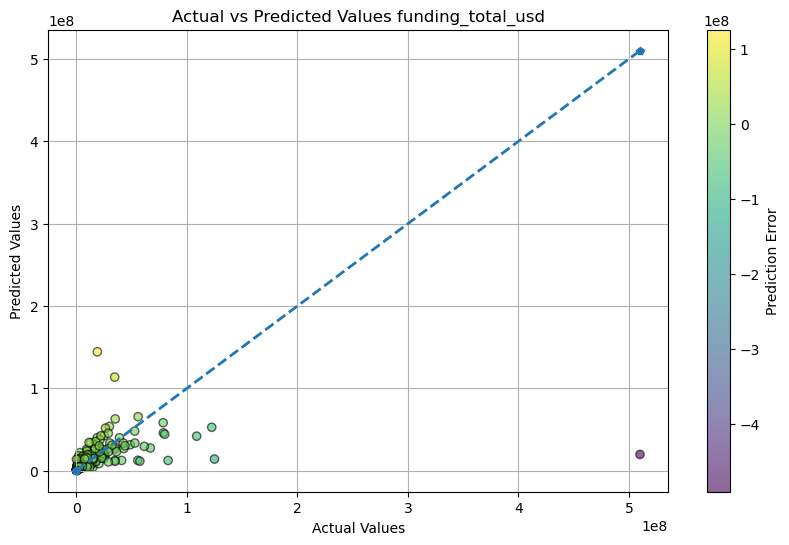

<Figure size 1000x800 with 0 Axes>

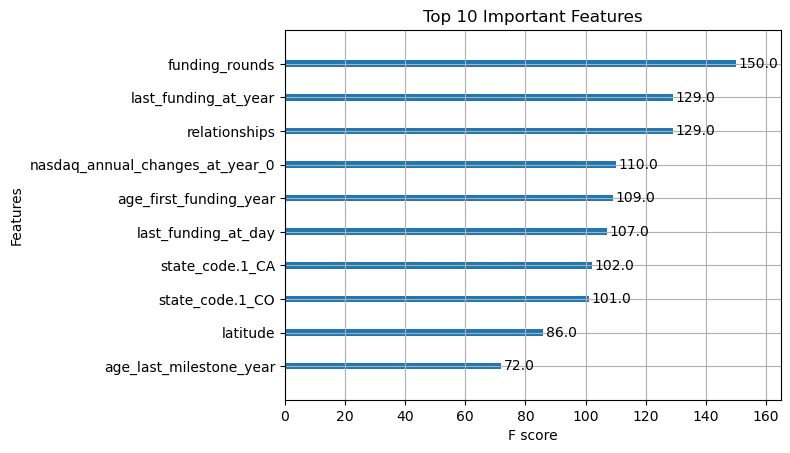

Accuracy within 1 mln usd: 68.65%


In [48]:
# Preprocess and split the data train and evaluate:
X = preprocess_data(df, useKNNImputer=True)
y = df['funding_total_usd'] # Create target
X = X.drop('funding_total_usd', axis=1)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'funding_total_usd', tolerance = 0.4)
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} mln usd: {accuracy_abs * 100:.2f}%")

## milestones

Mean Squared Error (MSE): 0.72
Mean Absolute Error (MAE): 0.63
R-squared (R²): 0.5
Custom Accuracy (within ±10%): 21.62%


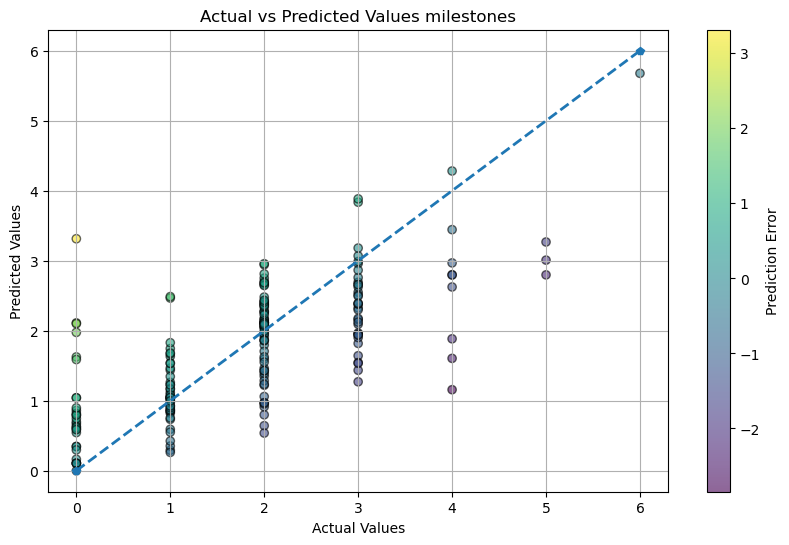

<Figure size 1000x800 with 0 Axes>

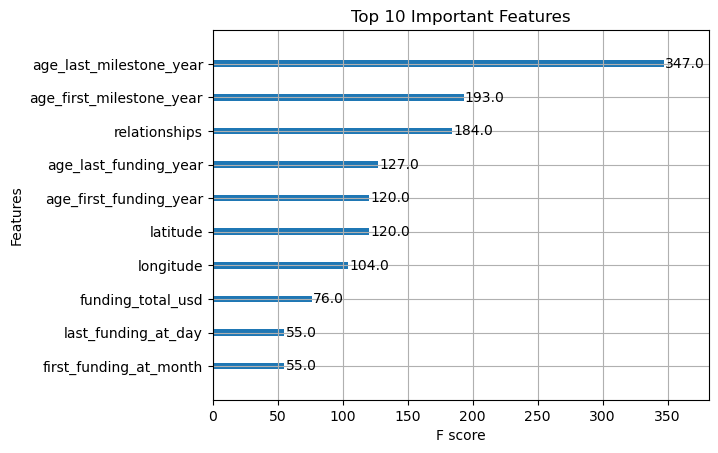

Accuracy within 1 mln usd: 82.70%


In [49]:
# Create target
y = df['milestones']
df1 = df.copy()
df1 = df1.drop('milestones', axis=1)

# Preprocess and split the data train and evaluate:
X = preprocess_data(df1, useKNNImputer=True)
xgb_regressor, X_test, y_test, y_pred = train_and_evaluate_r(X, y, random_state, 'milestones')
accuracy_abs = (abs((y_pred - y_test) / y_test) <= 1).mean()
print(f"Accuracy within {1} mln usd: {accuracy_abs * 100:.2f}%")

In [50]:
'age_first_funding_year', 'age_last_funding_year',
'age_first_milestone_year', 'age_last_milestone_year', 'funding_rounds', 'funding_total_usd',
'milestones'

'milestones'